In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import functools
import itertools

from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met

from tomo2seg.data import volume_precipitates_dryrun as volume_paths, ModelPaths
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz

In [3]:
dimensions = (500, 500, 500)
dtype = "uint8"  # todo remove the cast inside the generator?

# prefill the function `HST_read`
_hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

hst_read = lambda x: _hst_read(str(x))

labels_list = [0, 1, 2]

class labels:
    matrix = 0
    fiber = 1
    hole = 2

In [4]:
# get a distribution strategy to use both gpus
# see https://www.tensorflow.org/guide/distributed_training
mirrored_strategy = tf.distribute.MirroredStrategy()  # todo add strategy to metadata

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')



## Validation volume

In [5]:
val_volume = hst_read(volume_paths.val_data_path)
val_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

In [6]:
val_labels_volume = hst_read(volume_paths.val_labels_path)
val_labels_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

## Train volume

In [7]:
train_volume = hst_read(volume_paths.train_data_path)
train_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

In [8]:
train_labels_volume = hst_read(volume_paths.train_data_path)
train_labels_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

# Model

In [9]:
model_name = "dryrun-03"
model_paths = ModelPaths(model_name)

In [10]:
with mirrored_strategy.scope():
    model = tf.keras.models.load_model(str(model_paths.autosaved_model_path) + ".hdf5")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

# Processing

In [11]:
volume = train_volume
z_coord = 100
crop_size = 224

z_slice = volume[:, :, z_coord]
slice_dims = z_slice.shape

## Generate the crops

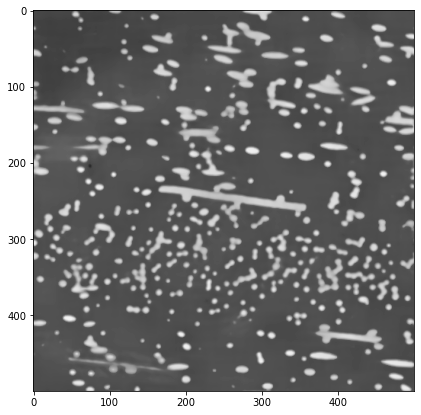

In [19]:
sz=7
fig, ax = plt.subplots(1, 1, figsize=(sz, sz))
ax.imshow(z_slice, cmap=cm.gray, vmin=0, vmax=255)

In [20]:
n_steps = (
    int(np.ceil(slice_dims[0] / 224)), 
    int(np.ceil(slice_dims[1] / 224))
)
n_steps

(3, 3)

In [21]:
# coordinates (xs and yx) of the upper left corners of the crops
x0s, y0s = tuple(np.linspace(0, slice_dims[dim] - crop_size, n_steps[dim]) for dim in (0, 1))
x0s, y0s = (tuple(map(int, x0s)), tuple(map(int, y0s)))
x0s, y0s

((0, 138, 276), (0, 138, 276))

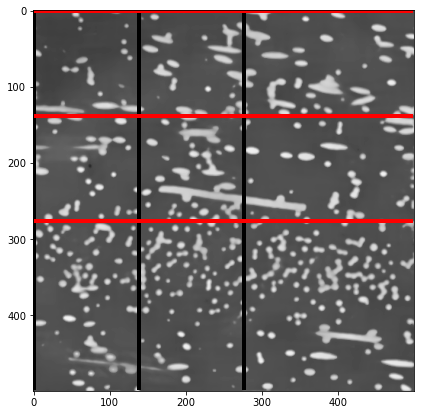

In [23]:
sz=7
fig, ax = plt.subplots(1, 1, figsize=(sz, sz))
ax.imshow(z_slice, cmap=cm.gray, vmin=0, vmax=255)

for x_ in x0s:
    ax.vlines(x_, 0, slice_dims[1] - 1, color='k', linewidth=4)

for y_ in y0s:
    ax.hlines(y_, 0, slice_dims[0] - 1, color='r', linewidth=4)

In [24]:
crops_coordinates = np.array([
    ((x0, x0 + crop_size), (y0 ,y0 + crop_size))
    for x0, y0 in itertools.product(x0s, y0s)
], dtype=tuple).reshape(len(x0s), len(y0s), 2, 2)
crops_coordinates

array([[[[0, 224],
         [0, 224]],

        [[0, 224],
         [138, 362]],

        [[0, 224],
         [276, 500]]],


       [[[138, 362],
         [0, 224]],

        [[138, 362],
         [138, 362]],

        [[138, 362],
         [276, 500]]],


       [[[276, 500],
         [0, 224]],

        [[276, 500],
         [138, 362]],

        [[276, 500],
         [276, 500]]]], dtype=object)

In [25]:
crops_coordinates_sequential = crops_coordinates.reshape(-1, 2, 2)
crops_coordinates_sequential

array([[[0, 224],
        [0, 224]],

       [[0, 224],
        [138, 362]],

       [[0, 224],
        [276, 500]],

       [[138, 362],
        [0, 224]],

       [[138, 362],
        [138, 362]],

       [[138, 362],
        [276, 500]],

       [[276, 500],
        [0, 224]],

       [[276, 500],
        [138, 362]],

       [[276, 500],
        [276, 500]]], dtype=object)

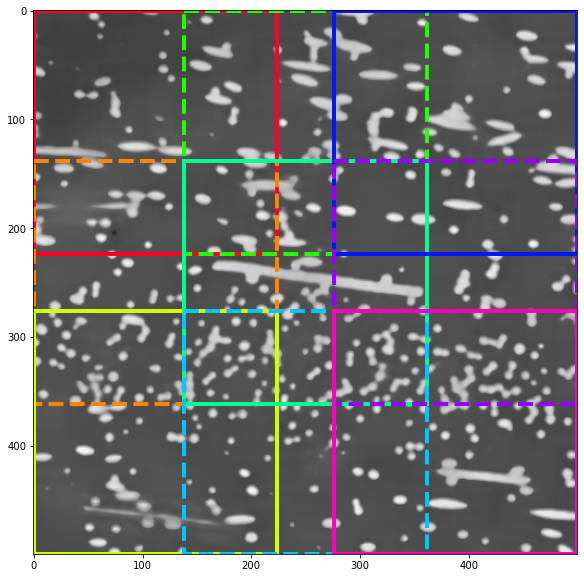

In [26]:
sz=10
fig, ax = plt.subplots(1, 1, figsize=(sz, sz))
ax.imshow(z_slice, cmap=cm.gray, vmin=0, vmax=255)

get_frame = functools.partial(
    patches.Rectangle,
    linewidth=4,
    facecolor='none',
)
linestyles = ['-', '--']

rainbow = plt.get_cmap('gist_rainbow')

# p is just a number beween 0 and 1 that represents
# the percentage of the linear path in the color space
for i, (((x0, x1), (y0, y1)), p) in enumerate(zip(crops_coordinates_sequential, np.linspace(0, 1, len(crops_coordinates_sequential)))):
    xy = (x0, y0) 
    width = x1 - x0
    height = y1 - y0
    frame = get_frame(xy, width, height, edgecolor=rainbow(p), ls=linestyles[i%len(linestyles)])
    ax.add_patch(frame)


In [27]:
(x0, x1), (y0, y1) = crops_coordinates[0, 0].tolist()

In [28]:
crops = np.array([
    [
        z_slice[x0:x1, y0:y1]
        for j in range(crops_coordinates.shape[1])
        for (x0, x1), (y0, y1) in [crops_coordinates[i, j].tolist()]
    ]
    for i in range(crops_coordinates.shape[0])
])
crops.shape, crops.dtype

((3, 3, 224, 224), dtype('uint8'))

In [29]:
sz=16
gridspace = .02
mysubplots = functools.partial(
    plt.subplots,
    figsize=(sz, sz), 
    sharey=True, 
    sharex=True, 
    gridspec_kw={"wspace": gridspace, "hspace": gridspace}
)

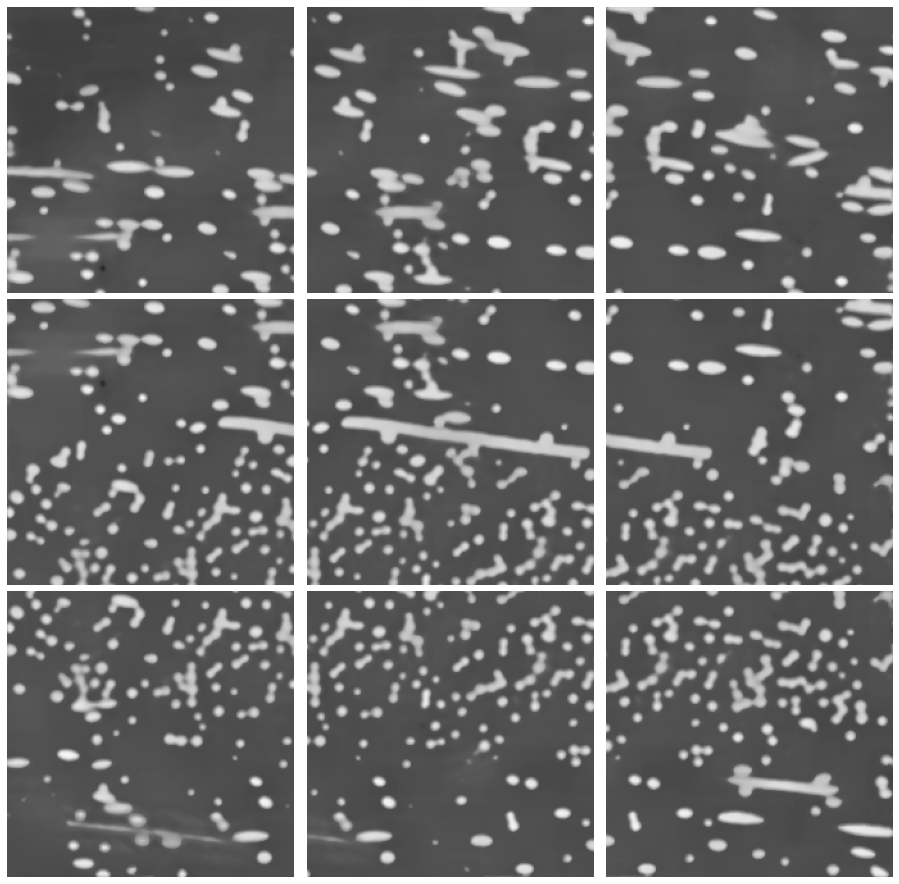

In [30]:
fig, axs = mysubplots(crops.shape[0], crops.shape[1])
for crop, ax in zip(crops.reshape(-1, crop_size, crop_size), axs.ravel()):
    ax.imshow(crop, cmap=cm.gray, vmin=0, vmax=255)
    ax.axis('off')

## Segment

(1, 224, 224, 1)
(1, 224, 224, 3)
(1, 224, 224)
(224, 224)


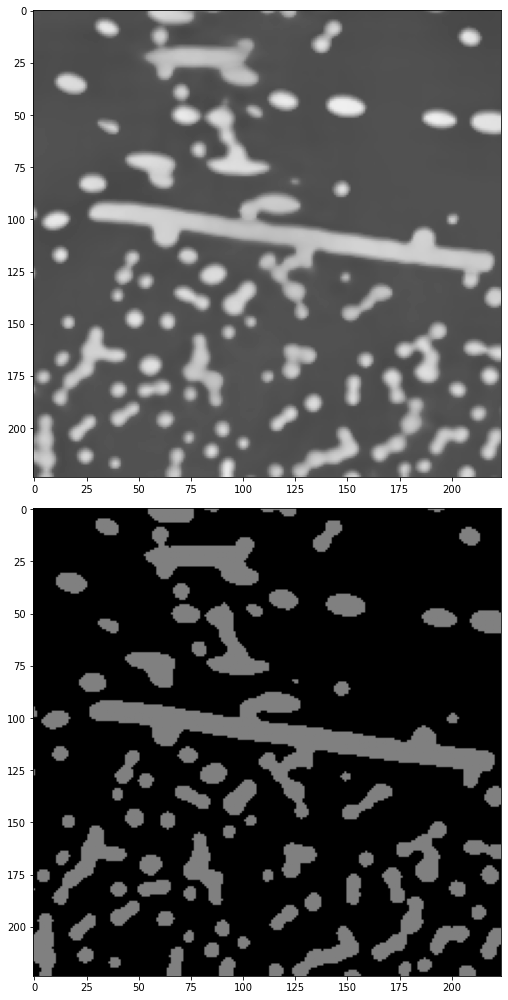

In [40]:
crop_ij = (1, 1)
crop_data = crops[crop_ij[0], crop_ij[1], :, :]

crop_data_modelin = crop_data.reshape(-1, crop_size, crop_size, 1) / 255  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print(crop_data_modelin.shape)

crop_probas = model.predict(crop_data_modelin, batch_size=1)
print(crop_probas.shape)

crop_preds = crop_probas.argmax(axis=-1)
print(crop_preds.shape)

crop_preds_im = crop_preds.reshape(224, 224) 
print(crop_preds_im.shape)

sz = 14
fig = plt.figure(figsize=(2 * sz, sz))
fig.set_tight_layout(True)

ax = plt.subplot(211)
ax.imshow(crop_data, vmin=0, vmax=255, cmap=cm.gray)

ax = plt.subplot(212)
plt.imshow(crop_preds_im, vmin=0, vmax=2, cmap=cm.gray)

In [41]:
proba_crops = np.empty(list(crops.shape) + [3], dtype=np.float)
proba_crops.shape, proba_crops.dtype

((3, 3, 224, 224, 3), dtype('float64'))

In [42]:
pred_crops = np.empty_like(crops)
pred_crops.shape, pred_crops.dtype

((3, 3, 224, 224), dtype('uint8'))

In [46]:
ij_iterator = itertools.product(range(pred_crops.shape[0]), range(pred_crops.shape[1]))

for i, j in ij_iterator:
    proba_crops[i, j, :, :, :] = model.predict(crops[i, j, :, :].reshape(-1, crop_size, crop_size, 1) / 255)  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    pred_crops[i, j, :, :] = proba_crops[i, j, :, :].argmax(axis=-1)

(224, 224, 3)


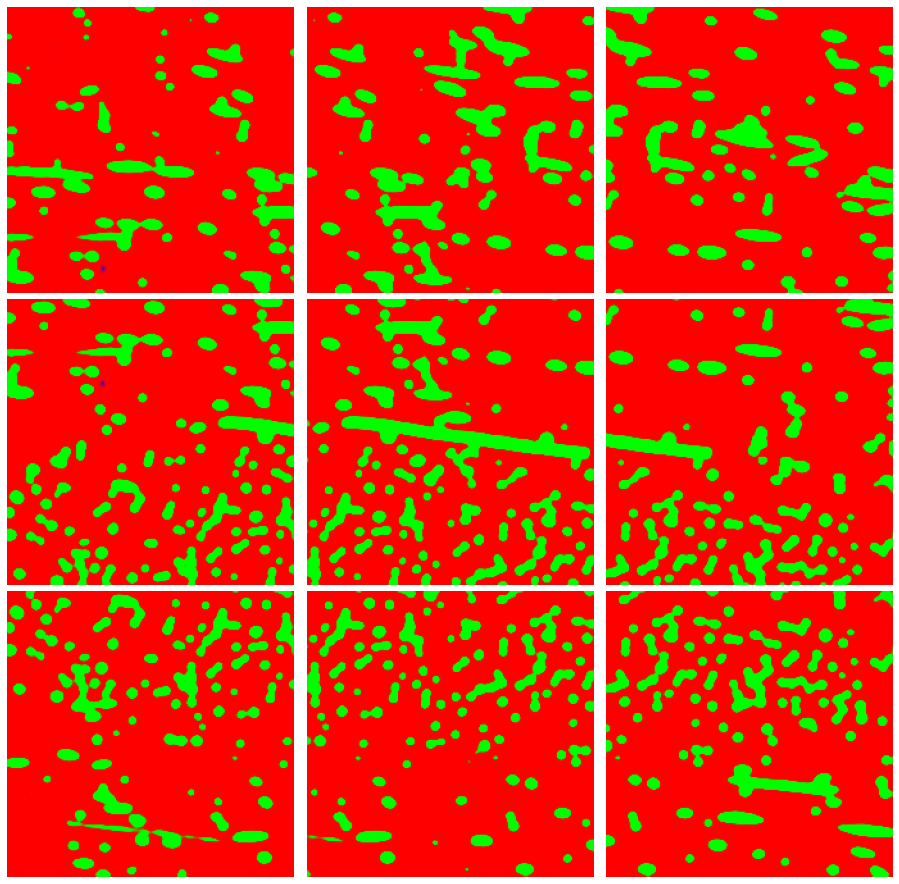

In [49]:
fig, axs = mysubplots(crops.shape[0], crops.shape[1])
for proba_crop, ax in zip(proba_crops.reshape(-1, crop_size, crop_size, proba_crops.shape[-1]), axs.ravel()):
    ax.imshow(proba_crop)  # interpreted as rgb if there are 3 classes
    ax.axis('off')
print(proba_crop.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


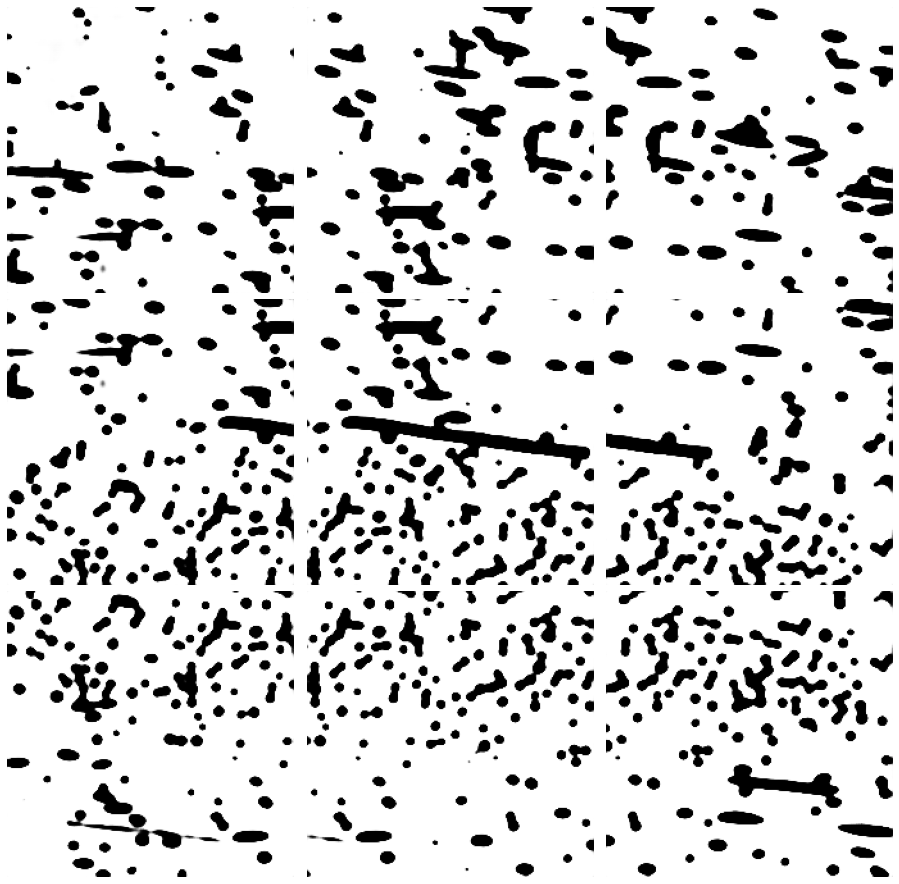

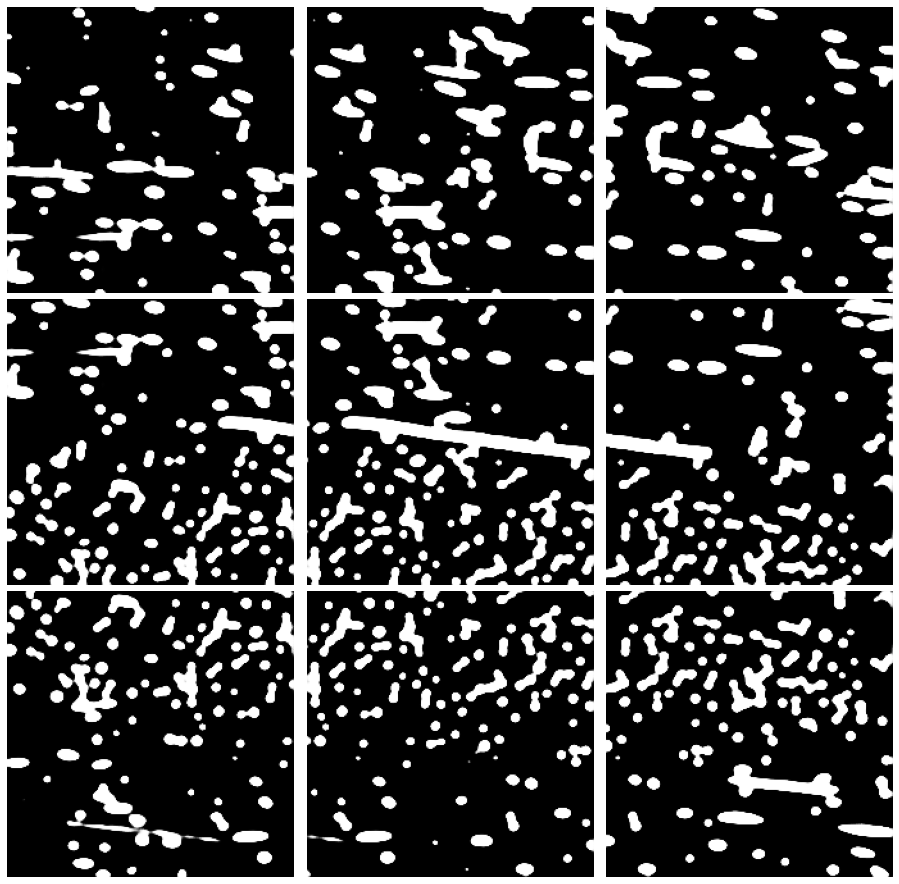

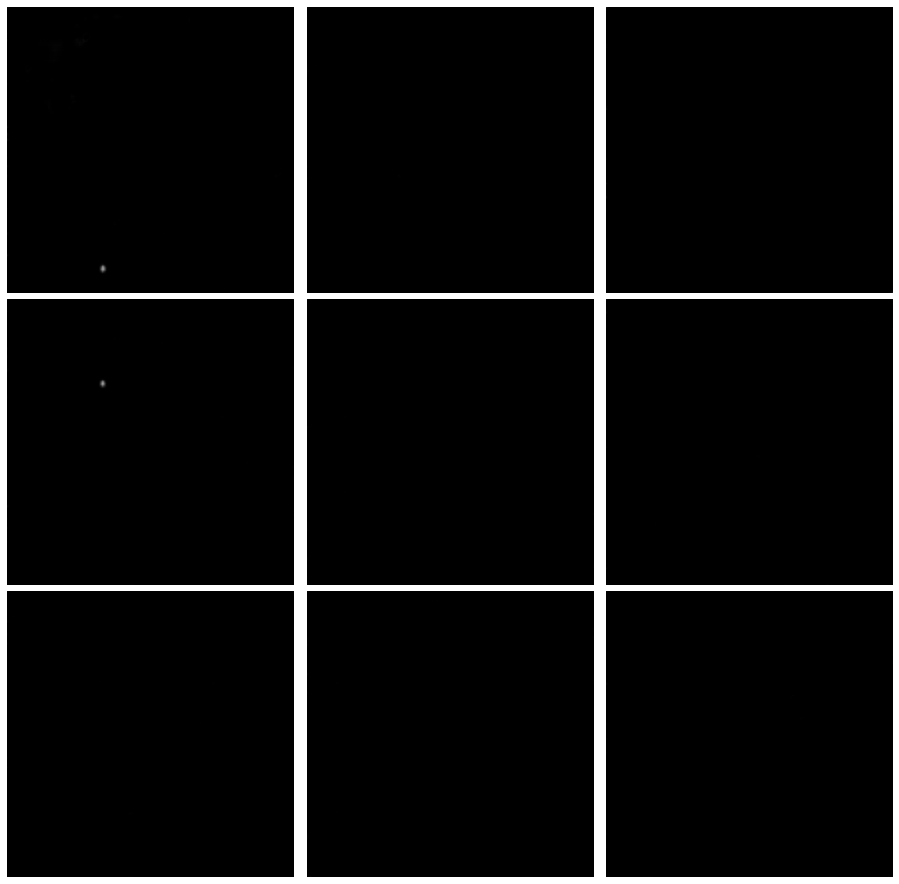

In [51]:
for class_ in [0, 1, 2]:
    fig, axs = mysubplots(crops.shape[0], crops.shape[1])
    for proba_crop, ax in zip(proba_crops.reshape(-1, crop_size, crop_size, proba_crops.shape[-1]), axs.ravel()):
        ax.imshow(proba_crop[:, :, class_], vmin=0, vmax=1, cmap=cm.gray)  # interpreted as rgb if there are 3 classes
        ax.axis('off')
    print(proba_crop.shape)

(224, 224)


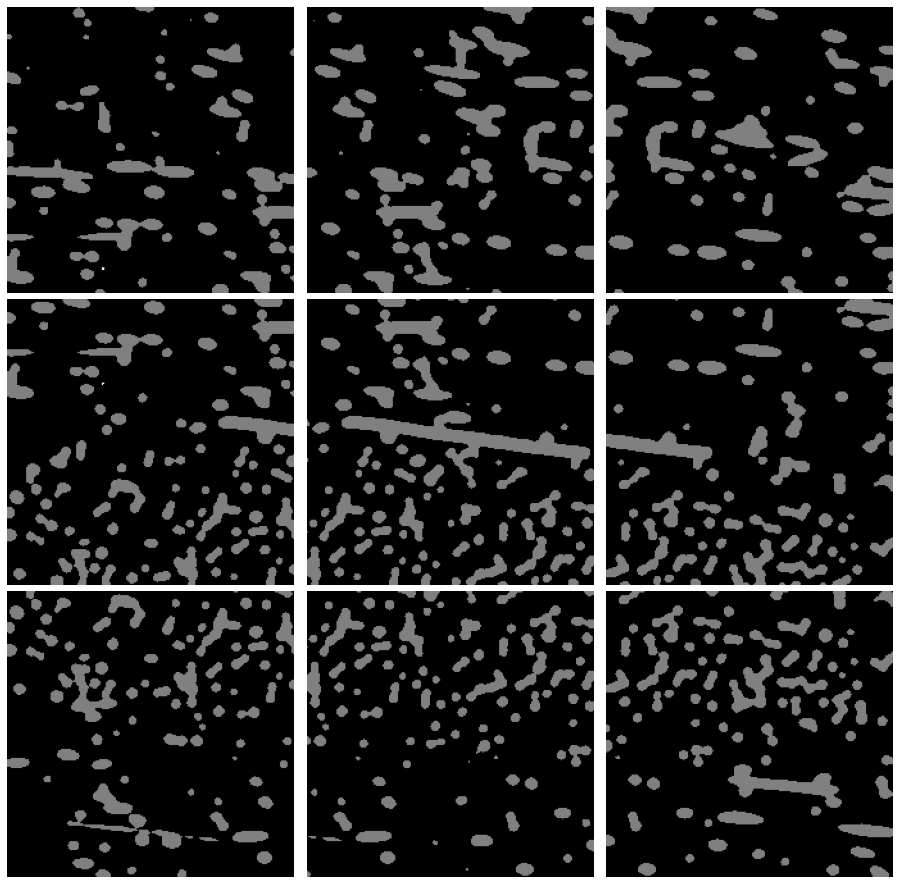

In [52]:
fig, axs = mysubplots(crops.shape[0], crops.shape[1])

for pred_crop, ax in zip(pred_crops.reshape(-1, crop_size, crop_size), axs.ravel()):
    ax.imshow(pred_crop, vmin=0, vmax=2, cmap='gray')
    ax.axis('off')
print(pred_crop.shape)

# Rebuild the slice

In [53]:
rebuilt_slice = np.empty

# CONTINUE FROM HERE

In [54]:
X_sums = np.zeros_like(X).astype(np.int16)
X_counts = np.zeros_like(X)
for crop, ((x0, x1), (y0, y1)) in zip(crops, bins):
    X_sums[x0:x1, y0:y1] += crop
    X_counts[x0:x1, y0:y1] += np.ones_like(crop)
X_reconstructed = (X_sums / X_counts).astype(np.uint8)

NameError: name 'X' is not defined

In [ ]:
plt.imshow(X_counts, cmap=cm.gray, vmin=0, vmax=4)

In [120]:
from matplotlib import cm

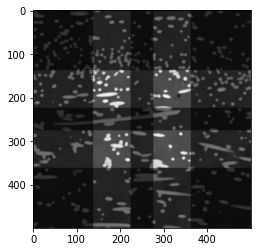

In [121]:
plt.imshow(X_sums, cmap=cm.gray)

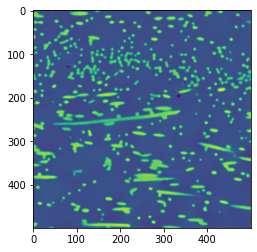

In [122]:
plt.imshow(X_reconstructed)

In [123]:
assert all((X == X_reconstructed).ravel())

## Validation

In [7]:
val_pred = np.load("val-pred-classes.npy")

# Examples

In [8]:
from skimage import data, segmentation
from skimage import filters
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def plot_border(idx, generator, predictions):    
    img = generator[idx][0].reshape(224, 224)
    gt = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
    pred = predictions[idx]

    gt_mask_fiber = gt == labels.fiber
    gt_mask_hole = gt == labels.hole
    
    gt_edges_fiber = segmentation.find_boundaries(gt_mask_fiber)
    gt_edges_fiber = np.ma.masked_where(~gt_edges_fiber, gt_edges_fiber)

    gt_edges_hole = segmentation.find_boundaries(gt_mask_hole)
    gt_edges_hole = np.ma.masked_where(~gt_edges_hole, gt_edges_hole)
    
    pred_mask_fiber = pred == labels.fiber
    pred_mask_hole = pred == labels.hole
    
    pred_edges_fiber = segmentation.find_boundaries(pred_mask_fiber)
    pred_edges_fiber = np.ma.masked_where(~pred_edges_fiber, pred_edges_fiber)

    pred_edges_hole = segmentation.find_boundaries(pred_mask_hole)
    pred_edges_hole = np.ma.masked_where(~pred_edges_hole, pred_edges_hole)

    sz = 10
    fig, axs = plt.subplots(2, 2, figsize=(sz, sz), dpi=200)
    fig.tight_layout()
    for ax in axs.ravel():
        ax.axis('off')
    
    # upper left
    axs[0, 0].imshow(img, cmap='gray')
    axs[0, 0].set_title("Image")
    
    # upper right
    axs[0, 1].imshow(img, cmap='gray')
    axs[0, 1].imshow(gt_edges_fiber, cmap=ListedColormap(['blue']), interpolation=None)
    axs[0, 1].imshow(gt_edges_hole, cmap=ListedColormap(['yellow']), interpolation=None)
    axs[0, 1].set_title("Ground truth")
    
    # bottom left
    axs[1, 0].imshow(img, cmap='gray')
    axs[1, 0].imshow(pred_edges_fiber, cmap=ListedColormap(['red']), interpolation=None)
    axs[1, 0].imshow(pred_edges_hole, cmap=ListedColormap(['magenta']), interpolation=None)
    axs[1, 0].set_title("Prediction")
    
    # bottom right
    axs[1, 1].imshow(img, cmap='gray')
    axs[1, 1].imshow(gt_edges_fiber, cmap=ListedColormap(['blue']), interpolation=None)
    axs[1, 1].imshow(gt_edges_hole, cmap=ListedColormap(['yellow']), interpolation=None)
    axs[1, 1].imshow(pred_edges_fiber, cmap=ListedColormap(['red']), interpolation=None)
    axs[1, 1].imshow(pred_edges_hole, cmap=ListedColormap(['magenta']), interpolation=None)
    axs[1, 1].set_title("Ground truth X Prediction")
 
    
plot_border_val = functools.partial(plot_border, generator=val, predictions=val_pred)  

In [9]:
def plot_pred(generator, predictions, idx, label):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    viz.show_slice(
        ax, 
        generator[idx][0].reshape(224, 224), 
        (~(predictions[idx] == label)).astype(int)
    )
    

def plot_label(generator, idx, label):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    viz.show_slice(
        ax, 
        generator[idx][0].reshape(224, 224), 
        (~(generator[idx][1].reshape(224, 224, 3).argmax(axis=2) == label)).astype(int)
    )

In [13]:
# plot_train_label = functools.partial(plot_label, generator=train)
# plot_train_pred = functools.partial(plot_pred, generator=train, predictions=train_pred)

plot_val_label = functools.partial(plot_label, generator=val)
plot_val_pred = functools.partial(plot_pred, generator=val, predictions=val_pred)

# Find some bad segmentations

## Image accuracy

In [14]:
accuracies = []
for idx in range(len(val)):
    truth = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
    pred = val_pred[idx]

    accuracies.append(
        (truth == pred).sum() / (truth.shape[0] * truth.shape[1])
    )

In [15]:
accuracies_sort = np.argsort(accuracies)

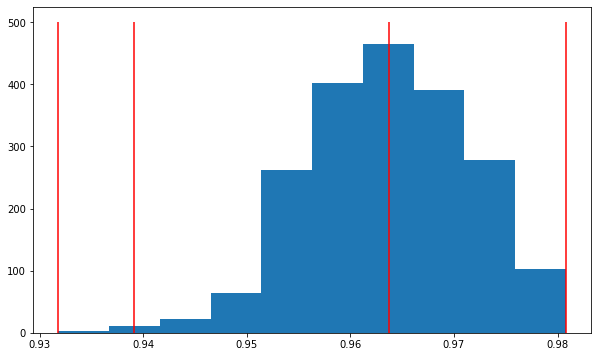

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(accuracies)
ax.vlines([accuracies[accuracies_sort[p]] for p in [0, 10, 1000, -1]], 0, 500, color='red')

## Cross entropy

In [21]:
val_pred_probas = np.load("val-pred-probas.npy")

In [22]:
losses = []
for idx in tqdm(range(len(val))):
    truth = val[idx][1].reshape(224, 224, 3).argmax().ravel()
    truth = val[idx][1].reshape(224, 224, 3).reshape(-1, 3)
    pred = val_pred_probas[idx].reshape(-1, 3)

    losses.append(met.log_loss(truth, pred))

In [23]:
losses_sort = np.argsort(losses)

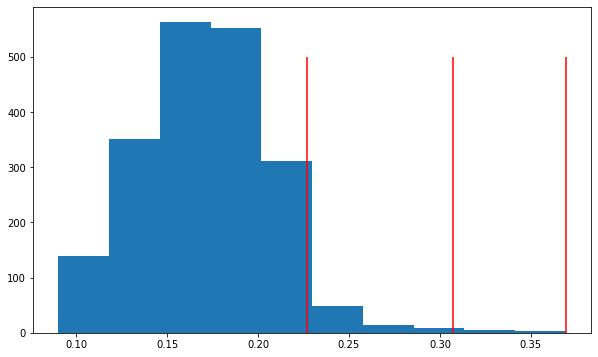

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(losses)
ax.vlines([losses[losses_sort[p]] for p in [-100, -10, -1]], 0, 500, color='red')

## Error blobs

In [10]:
idx = 0
generator = val
predictions = val_pred
img = generator[idx][0].reshape(224, 224)
gt = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
pred = predictions[idx]

In [11]:
import skimage

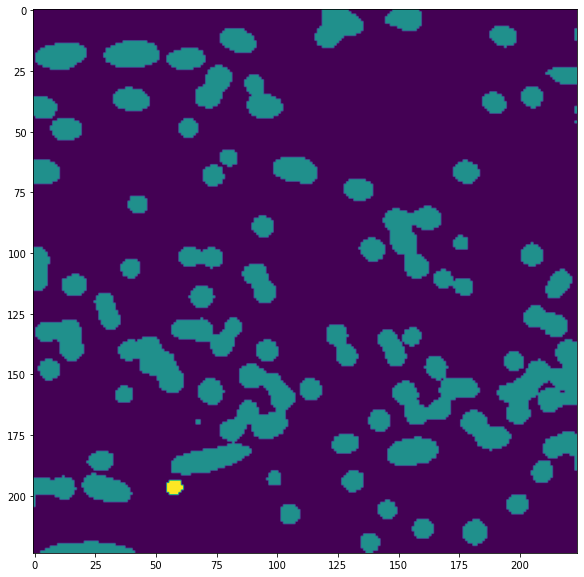

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(gt)

blobs, n_blobs = skimage.measure.label(gt, connectivity=2, return_num=True, background=0)

In [14]:
n_blobs

75

In [15]:
blob_stack = [(blobs == i).reshape(*blobs.shape, 1) for i in range(n_blobs + 1)]
blob_stack = np.concatenate(blob_stack, axis=2)

In [ ]:
blob